### Data analysis and a simple decision tree example using data from https://www.kaggle.com/uciml/zoo-animal-classification

### from Part-2 analysis, we know the gini index scores. Based on that we select following columns only.


In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from collections import Counter
import math as math
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

Read the data file

In [2]:
zoo_df = pd.read_csv("data\Decision-Tree_Zoo-Data\zoo-animal-classification\zoo.csv")

Check if we are missing any data

In [3]:
zoo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
animal_name    101 non-null object
hair           101 non-null int64
feathers       101 non-null int64
eggs           101 non-null int64
milk           101 non-null int64
airborne       101 non-null int64
aquatic        101 non-null int64
predator       101 non-null int64
toothed        101 non-null int64
backbone       101 non-null int64
breathes       101 non-null int64
venomous       101 non-null int64
fins           101 non-null int64
legs           101 non-null int64
tail           101 non-null int64
domestic       101 non-null int64
catsize        101 non-null int64
class_type     101 non-null int64
dtypes: int64(17), object(1)
memory usage: 14.3+ KB


animal_name is not useful in classification. remove it from data set

In [4]:
animal_names = zoo_df['animal_name'].to_list()
print(animal_names)
zoo_df = zoo_df.drop('animal_name', axis=1)

['aardvark', 'antelope', 'bass', 'bear', 'boar', 'buffalo', 'calf', 'carp', 'catfish', 'cavy', 'cheetah', 'chicken', 'chub', 'clam', 'crab', 'crayfish', 'crow', 'deer', 'dogfish', 'dolphin', 'dove', 'duck', 'elephant', 'flamingo', 'flea', 'frog', 'frog', 'fruitbat', 'giraffe', 'girl', 'gnat', 'goat', 'gorilla', 'gull', 'haddock', 'hamster', 'hare', 'hawk', 'herring', 'honeybee', 'housefly', 'kiwi', 'ladybird', 'lark', 'leopard', 'lion', 'lobster', 'lynx', 'mink', 'mole', 'mongoose', 'moth', 'newt', 'octopus', 'opossum', 'oryx', 'ostrich', 'parakeet', 'penguin', 'pheasant', 'pike', 'piranha', 'pitviper', 'platypus', 'polecat', 'pony', 'porpoise', 'puma', 'pussycat', 'raccoon', 'reindeer', 'rhea', 'scorpion', 'seahorse', 'seal', 'sealion', 'seasnake', 'seawasp', 'skimmer', 'skua', 'slowworm', 'slug', 'sole', 'sparrow', 'squirrel', 'starfish', 'stingray', 'swan', 'termite', 'toad', 'tortoise', 'tuatara', 'tuna', 'vampire', 'vole', 'vulture', 'wallaby', 'wasp', 'wolf', 'worm', 'wren']


In [5]:
#One-of-K Encode the "legs" column data
onehot_encoder = OneHotEncoder(sparse=False, categories = "auto", dtype=np.int)
onehot_encoded = onehot_encoder.fit_transform(zoo_df["legs"].values.reshape(-1,1))

# prepare column names
legs_clm_names = list()
col_index = 0
for name in onehot_encoder.categories_[0]:
    zoo_df["legs" + str(name)] = onehot_encoded[:, col_index]
    col_index = col_index + 1
zoo_df = zoo_df.drop("legs", axis=1)

In [6]:
for column in zoo_df.columns:
    zoo_df[column] = zoo_df[column].astype("category")

In [7]:
zoo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 22 columns):
hair          101 non-null category
feathers      101 non-null category
eggs          101 non-null category
milk          101 non-null category
airborne      101 non-null category
aquatic       101 non-null category
predator      101 non-null category
toothed       101 non-null category
backbone      101 non-null category
breathes      101 non-null category
venomous      101 non-null category
fins          101 non-null category
tail          101 non-null category
domestic      101 non-null category
catsize       101 non-null category
class_type    101 non-null category
legs0         101 non-null category
legs2         101 non-null category
legs4         101 non-null category
legs5         101 non-null category
legs6         101 non-null category
legs8         101 non-null category
dtypes: category(22)
memory usage: 4.6 KB


A glance over the data

In [8]:
zoo_df

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,...,tail,domestic,catsize,class_type,legs0,legs2,legs4,legs5,legs6,legs8
0,1,0,0,1,0,0,1,1,1,1,...,0,0,1,1,0,0,1,0,0,0
1,1,0,0,1,0,0,0,1,1,1,...,1,0,1,1,0,0,1,0,0,0
2,0,0,1,0,0,1,1,1,1,0,...,1,0,0,4,1,0,0,0,0,0
3,1,0,0,1,0,0,1,1,1,1,...,0,0,1,1,0,0,1,0,0,0
4,1,0,0,1,0,0,1,1,1,1,...,1,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,1,0,0,0,1,1,1,...,1,0,1,1,0,1,0,0,0,0
97,1,0,1,0,1,0,0,0,0,1,...,0,0,0,6,0,0,0,0,1,0
98,1,0,0,1,0,0,1,1,1,1,...,1,0,1,1,0,0,1,0,0,0
99,0,0,1,0,0,0,0,0,0,1,...,0,0,0,7,1,0,0,0,0,0


In [9]:
# assumes x and y are categorical data
def calc_gini_split_quality(feature, y_actual):
    feature_set = set(feature)
    total_count = float(len(feature))
    
    gini_split_quality = 0
    for fea in feature_set:
        fea_mask = feature == fea
        y_values = y_actual[fea_mask]
        num_items_at_node = len(y_values)
        class_counter = Counter(y_values)
        gini_index = 0
        for clas, count in class_counter.items():
            print("Feature Value = ", fea, "Class = ", clas, "Count ", count, " of ", num_items_at_node)
            gini_index = gini_index + (count/num_items_at_node)**2
        gini_index = 1 - gini_index
        print("Gini Index: ", gini_index)
        gini_split_quality = gini_split_quality + (num_items_at_node/total_count) * gini_index
    print("gini split quality ", gini_split_quality)
    return gini_split_quality

In [10]:
columns= list(zoo_df.columns)
columns.remove("class_type")
print(columns)

['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'tail', 'domestic', 'catsize', 'legs0', 'legs2', 'legs4', 'legs5', 'legs6', 'legs8']


In [11]:
# copy X columns
X = zoo_df.loc[:, zoo_df.columns != 'class_type']
y = zoo_df['class_type']

ginies = list()
for column_index in range(X.shape[1]):
    print(columns[column_index])
    gini_split_quality = calc_gini_split_quality(X[columns[column_index]], y)
    ginies.append((columns[column_index], gini_split_quality))

def index(tup):
    return tup[1]
ginies.sort(key=index, reverse=False)

hair
Feature Value =  0 Class =  4 Count  13  of  58
Feature Value =  0 Class =  2 Count  20  of  58
Feature Value =  0 Class =  7 Count  10  of  58
Feature Value =  0 Class =  1 Count  2  of  58
Feature Value =  0 Class =  6 Count  4  of  58
Feature Value =  0 Class =  5 Count  4  of  58
Feature Value =  0 Class =  3 Count  5  of  58
Gini Index:  0.7829964328180736
Feature Value =  1 Class =  1 Count  39  of  43
Feature Value =  1 Class =  6 Count  4  of  43
Gini Index:  0.1687398593834506
gini split quality  0.5214812579894718
feathers
Feature Value =  0 Class =  1 Count  41  of  81
Feature Value =  0 Class =  4 Count  13  of  81
Feature Value =  0 Class =  7 Count  10  of  81
Feature Value =  0 Class =  6 Count  8  of  81
Feature Value =  0 Class =  5 Count  4  of  81
Feature Value =  0 Class =  3 Count  5  of  81
Gini Index:  0.6867855509830818
Feature Value =  1 Class =  2 Count  20  of  20
Gini Index:  0.0
gini split quality  0.5507884121745508
eggs
Feature Value =  0 Class =  1 

Feature Value =  1 Class =  7 Count  2  of  2
Gini Index:  0.0
gini split quality  0.7382738273827383


In [12]:
ginies

[('milk', 0.46633663366336625),
 ('eggs', 0.4969913456236665),
 ('hair', 0.5214812579894718),
 ('feathers', 0.5507884121745508),
 ('toothed', 0.56757831520857),
 ('legs4', 0.6147960660727727),
 ('breathes', 0.6262022630834512),
 ('legs2', 0.6306405415316306),
 ('backbone', 0.6364997945577691),
 ('airborne', 0.63987827354164),
 ('fins', 0.6595806639487478),
 ('legs0', 0.6633111471682286),
 ('catsize', 0.6644953969081119),
 ('legs6', 0.6764443477314765),
 ('tail', 0.6872505712109672),
 ('aquatic', 0.6880680375729882),
 ('venomous', 0.7332321941871607),
 ('legs8', 0.7382738273827383),
 ('predator', 0.7482005343391482),
 ('legs5', 0.748910891089109),
 ('domestic', 0.7502596413487502)]

## Split the data into training and testing sets

In [13]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [14]:
# copy first N columns
num_features_to_use = 12
features = []
count = 0
for feature, score in ginies:
    features.append(feature)
    count+=1
    if count == num_features_to_use:
        break
#print(features)
#columns = ["toothed", "tail", "backbone", "legs4", "breathes", "legs0", "aquatic", "venomous", "hair", "eggs", "feathers", "milk"]
X = zoo_df[features]
# copy Y column (class)
y = zoo_df['class_type']

In [15]:
#oversampler = SMOTE(k_neighbors=1)
oversampler = RandomOverSampler()
X, y = oversampler.fit_resample(X, y)

In [16]:
# split the data (70-30 split)
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size = 0.30, stratify = y)

In [17]:
train_X

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 1]], dtype=object)

Build the machine learning model

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
model = DecisionTreeClassifier(criterion="gini", max_features=1)
model.fit(train_X, train_Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [20]:
print("Impurity measures ", model.tree_.impurity)

Impurity measures  [0.8571     0.46375    0.48940833 0.48611111 0.         0.
 0.         0.         0.8334375  0.8005361  0.72716049 0.66042078
 0.48979592 0.31065089 0.5        0.         0.         0.
 0.         0.         0.         0.47114813 0.445      0.
 0.38781163 0.         0.29065744 0.         0.        ]


Predict the class of test data

In [21]:
y_predicted = model.predict(test_X)

How good is the model?
check accuracy

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
print(accuracy_score(test_Y, y_predicted))

1.0


Build confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
c_matrix = confusion_matrix(test_Y, y_predicted)
print(c_matrix)

[[12  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 13  0  0]
 [ 0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0 13]]


In [26]:
from collections import Counter

In [27]:
print(Counter(test_Y))

Counter({6: 13, 7: 13, 5: 13, 3: 12, 2: 12, 4: 12, 1: 12})


In [28]:
print(Counter(y_predicted))

Counter({6: 13, 7: 13, 5: 13, 3: 12, 2: 12, 4: 12, 1: 12})


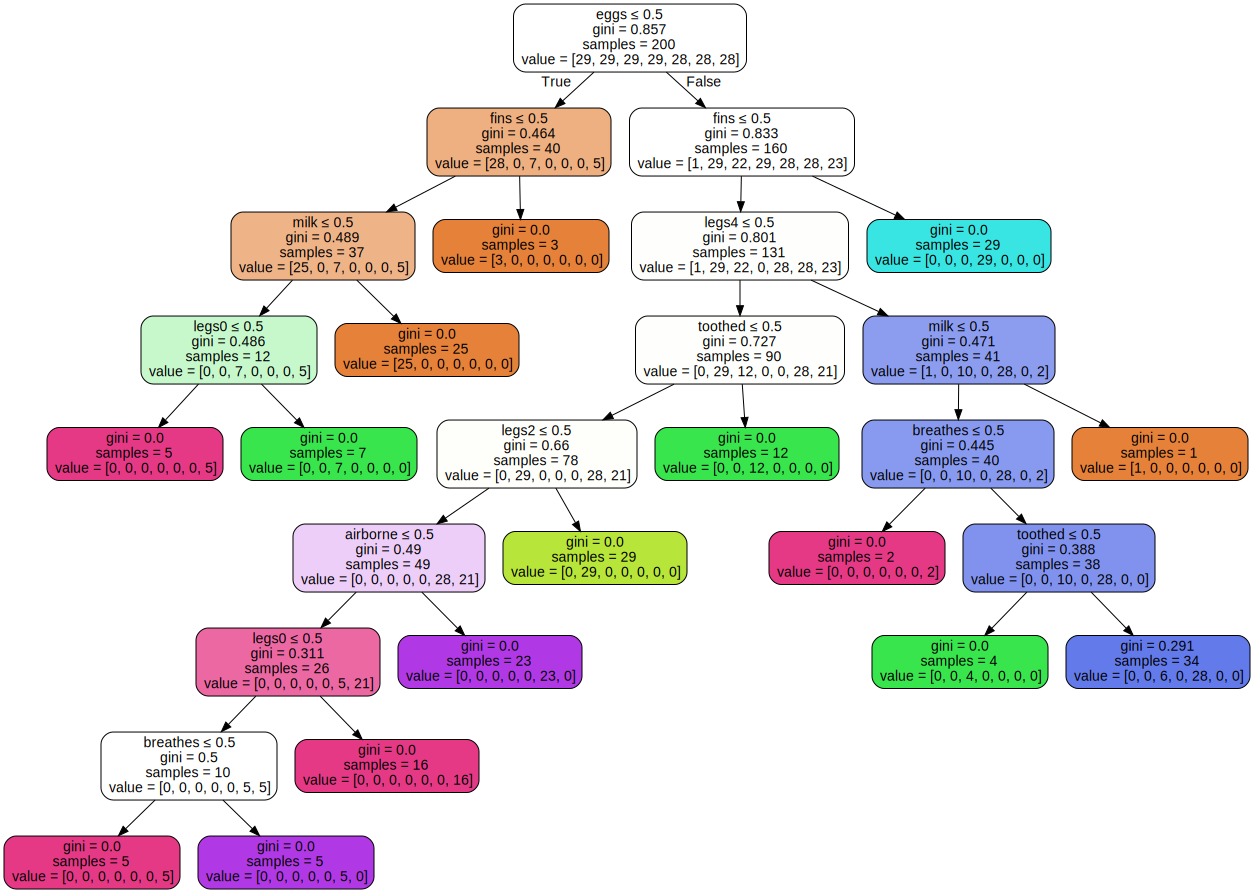

In [29]:
# plot the tree
# for graphing the tree
import graphviz as gv
from sklearn import tree

dot_data = tree.export_graphviz(model, out_file=None, filled=True, rounded = True, special_characters = True
                               , feature_names = features)
graph = gv.Source(dot_data)
graph

In [30]:
zoo_df[['milk', 'class_type']][zoo_df['milk'] == 1]

,milk,class_type
0,1,1
1,1,1
3,1,1
4,1,1
5,1,1
6,1,1
9,1,1
10,1,1
17,1,1
19,1,1
